* To set up, run: mamba activate oggm_env
* Using oggm_env (Python 3.12.2) kernel 

In [1]:
import oggm
from oggm import cfg, utils, workflow, tasks, graphics, DEFAULT_BASE_URL
# It will download a small subset of data used for testing and calibration 
# Those data are located in your home directory, in a hidden folder called .oggm
from oggm.sandbox import distribute_2d
from oggm.core import massbalance
from oggm.core.massbalance import mb_calibration_from_scalar_mb, mb_calibration_from_geodetic_mb, mb_calibration_from_wgms_mb

cfg.initialize()
# It will create a configuration file in your home folder, where you can indicate where you want to store further input data. 
# This configuration file is also located in your home directory under the name .oggm_config.

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import os

2024-04-29 16:12:51: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-04-29 16:12:51: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-04-29 16:12:51: oggm.cfg: Multiprocessing: using all available processors (N=2)


In [2]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')
# A call to cfg.initialize() will read the default parameter file (or any user-provided file) and
# make them available to all other OGGM tools via the cfg.PARAMS dictionary. 

cfg.PARAMS['melt_f'], cfg.PARAMS['ice_density'], cfg.PARAMS['continue_on_error']
cfg.PARAMS['border'] = 10
# You can try with or without multiprocessing: with two glaciers, OGGM could run on two processors
cfg.PARAMS['use_multiprocessing'] = True

# Local working directory (where OGGM will write its output)
# WORKING_DIR = utils.gettempdir('OGGM_distr4')
#cfg.PATHS['working_dir'] = utils.get_temp_dir('OGGM_distributed', reset=True)
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-calib-mb', reset=True)



2024-04-29 16:12:53: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-04-29 16:12:53: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-04-29 16:12:53: oggm.cfg: Multiprocessing: using all available processors (N=2)
2024-04-29 16:12:53: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-04-29 16:12:53: oggm.cfg: Multiprocessing switched ON after user settings.


In [3]:
# define the glaciers for the run 
# full list of IDs for nevados
rgi_ids = ['RGI60-17.13009', 'RGI60-17.13011', 'RGI60-17.13013', 'RGI60-17.13014', 'RGI60-17.13018', 'RGI60-17.13020', 'RGI60-17.13021', 
           'RGI60-17.13022', 'RGI60-17.13024', 'RGI60-17.13026', 'RGI60-17.13029', 'RGI60-17.13030', 'RGI60-17.13031', 'RGI60-17.13033', 
           'RGI60-17.13034', 'RGI60-17.13044', 'RGI60-17.13045', 'RGI60-17.13047', 'RGI60-17.13049', 'RGI60-17.13050', 'RGI60-17.13051', 
           'RGI60-17.13052', 'RGI60-17.13054', 'RGI60-17.13056', 'RGI60-17.13058'] 

In [4]:
# Let’s use OGGM to download the glacier directories for our two selected glaciers:
gdirs = workflow.init_glacier_directories(
    rgi_ids,  # which glaciers?
    prepro_base_url=DEFAULT_BASE_URL,  # where to fetch the data?
    from_prepro_level=4,  # what kind of data? (e.g. can try with 3 for mb data?)
    prepro_border=80  # how big of a map? (zoom level)
)

## add a last number (e.g. [0] or [1] to define which glacier in list of gdirs to run scenarios for)

2024-04-29 16:12:53: oggm.workflow: init_glacier_directories from prepro level 4 on 25 glaciers.
2024-04-29 16:12:53: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 25 glaciers


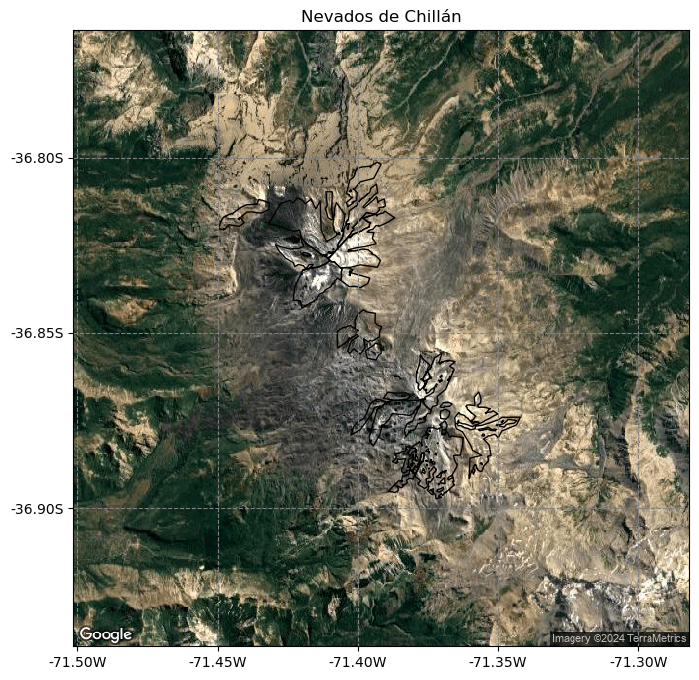

In [5]:
# map from google maps 
f, ax = plt.subplots(1,1,figsize=(8, 8))
graphics.plot_googlemap(gdirs, ax=ax)
ax.set_title('Nevados de Chillán');

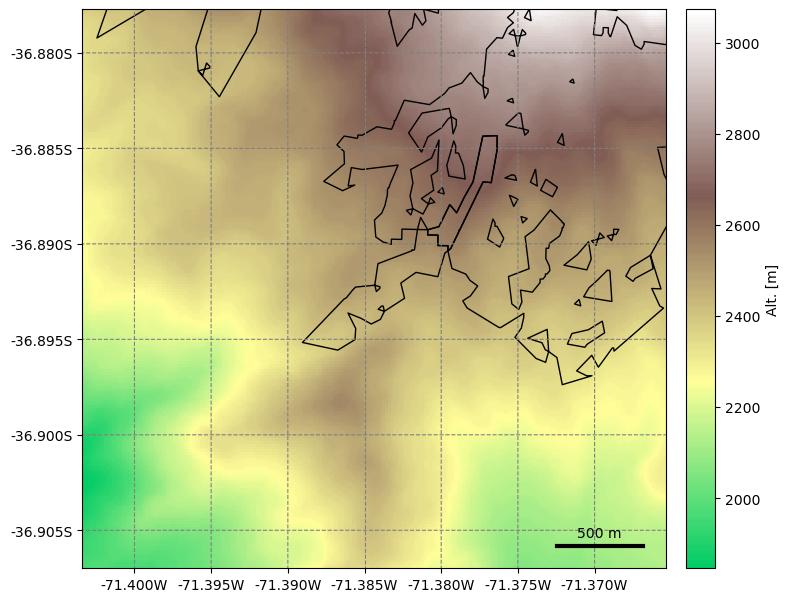

In [6]:
#alternative map option 
graphics.plot_domain(gdirs, figsize=(8, 8))

## Following the directions here:
 https://oggm.org/tutorials/stable/notebooks/advanced/massbalance_calibration.html#back-to-where-we-started-how-did-we-calibrate-the-default-pre-processed-directories-in-oggm-1-6

In [7]:
# Pick a glacier to look at climate info, #16 is Glaciar Nevado 
gdir_hef = gdirs[16]
gdir_hef.get_climate_info()

{'baseline_climate_source': 'GSWP3_W5E5',
 'baseline_yr_0': 1901,
 'baseline_yr_1': 2019,
 'baseline_climate_ref_hgt': 1675.0,
 'baseline_climate_ref_pix_lon': -71.25,
 'baseline_climate_ref_pix_lat': -36.75}

In [8]:
# Let’s have a look at the mass balance parameters for a glacier in the list
gdir_hef.read_json('mb_calib')
# mass balance from 2000-2020 is -783.5 [kg m-2]

#hmm.. mass balance error is larger than the total mass balance for many of the smaller glaciers,,, that's not good.... 

{'rgi_id': 'RGI60-17.13045',
 'bias': 0,
 'melt_f': 12.601531182265617,
 'prcp_fac': 1.4448853903798025,
 'temp_bias': -5.273351613897739,
 'reference_mb': -783.5,
 'reference_mb_err': 160.70000000000002,
 'reference_period': '2000-01-01_2020-01-01',
 'mb_global_params': {'temp_default_gradient': -0.0065,
  'temp_all_solid': 0.0,
  'temp_all_liq': 2.0,
  'temp_melt': -1.0},
 'baseline_climate_source': 'GSWP3_W5E5'}

In [9]:
# mass balance estimation for each glacier! over 20 year period 
for gdir in gdirs:
    mbmod = massbalance.MonthlyTIModel(gdir)
    mean_mb = mbmod.get_specific_mb(fls=gdir.read_pickle('inversion_flowlines'),
                                               year=np.arange(2000,2020,1)).mean()
    print(gdir.rgi_id, f': average MB 2000-2020 = {mean_mb:.1f} kg m-2, ',
          f"prcp_fac: {gdir.read_json('mb_calib')['prcp_fac']:.2f}")
    
# Biggest MB change is for RGI 17.13044, 13045, and 13050

RGI60-17.13009 : average MB 2000-2020 = -73.7 kg m-2,  prcp_fac: 1.88
RGI60-17.13011 : average MB 2000-2020 = -126.1 kg m-2,  prcp_fac: 1.44
RGI60-17.13013 : average MB 2000-2020 = -199.0 kg m-2,  prcp_fac: 1.44
RGI60-17.13014 : average MB 2000-2020 = -449.9 kg m-2,  prcp_fac: 1.44
RGI60-17.13018 : average MB 2000-2020 = -106.5 kg m-2,  prcp_fac: 1.44
RGI60-17.13020 : average MB 2000-2020 = -460.0 kg m-2,  prcp_fac: 1.44
RGI60-17.13021 : average MB 2000-2020 = -573.0 kg m-2,  prcp_fac: 1.44
RGI60-17.13022 : average MB 2000-2020 = -366.9 kg m-2,  prcp_fac: 1.44
RGI60-17.13024 : average MB 2000-2020 = -98.0 kg m-2,  prcp_fac: 1.44
RGI60-17.13026 : average MB 2000-2020 = -428.9 kg m-2,  prcp_fac: 1.44
RGI60-17.13029 : average MB 2000-2020 = -92.8 kg m-2,  prcp_fac: 1.44
RGI60-17.13030 : average MB 2000-2020 = -124.5 kg m-2,  prcp_fac: 1.44
RGI60-17.13031 : average MB 2000-2020 = -127.1 kg m-2,  prcp_fac: 1.44
RGI60-17.13033 : average MB 2000-2020 = -460.8 kg m-2,  prcp_fac: 1.44
RGI60-17.

## First, let’s check if the OGGM calibration worked at all

we will get first the average modelled MB:

In [33]:
h, w = gdir_hef.get_inversion_flowline_hw()
mb_geod = massbalance.MonthlyTIModel(gdir_hef)
# Note, if you change cfg.PARAMS['geodetic_mb_period'], you need to change the years here as well!
mbdf= pd.DataFrame(index = np.arange(1970,2020,1)) ## was originally from 2000 not 1970 
mbdf['mod_mb'] = mb_geod.get_specific_mb(h, w, year=mbdf.index)
mbdf.mean()

mod_mb   -221.18281
dtype: float64

then get the observed geodetic MB that we calibrated our mass-balance to:

In [11]:
print('reference MB: ' + str(gdir_hef.read_json('mb_calib')['reference_mb'])+ ' kg m-2')
print('reference MB uncertainties: '+ str(gdir_hef.read_json('mb_calib')['reference_mb_err'])+ ' kg m-2')
print('reference MB time period: ' + gdir_hef.read_json('mb_calib')['reference_period'])

reference MB: -783.5 kg m-2
reference MB uncertainties: 160.70000000000002 kg m-2
reference MB time period: 2000-01-01_2020-01-01


In [12]:
# #this tests if the two parameters are very similar: (they're not!!) not sure what to do with this info... 
# np.testing.assert_allclose(gdir_hef.read_json('mb_calib')['reference_mb'], mbdf['mod_mb'].mean())

# #AssertionError: 
# #Not equal to tolerance rtol=1e-07, atol=0
# #...
# #Mismatched elements: 1 / 1 (100%)

## interesting... modelled and observed MB look very different... not good lol

In [13]:
# if you use the default calibration data from Hugonnet et al., 2021, 
# we can get the geodetic data from any glacier from here:
ref_mb_df = utils.get_geodetic_mb_dataframe().loc[gdir_hef.rgi_id]
ref_mb_df = ref_mb_df.loc[ref_mb_df['period'] == cfg.PARAMS['geodetic_mb_period']].iloc[0]
# dmdtda: in meters water-equivalent per year -> we convert to kg m-2 yr-1
ref_mb = ref_mb_df['dmdtda'] * 1000
ref_mb

-783.5

In [14]:
# Let's calibrate the melt_f (this is the default option in mb_calibration_from_scalar_mb)
# overwrite_gdir has to be set to True,
# because we want to overwrite the old calibration
mb_calibration_from_scalar_mb(gdir_hef,
                              ref_mb = ref_mb, 
                              ref_period=cfg.PARAMS['geodetic_mb_period'],
                              overwrite_gdir=True);

mb_melt_f = massbalance.MonthlyTIModel(gdir_hef)
mbdf['mod_mb_melt_f'] = mb_melt_f.get_specific_mb(h, w, year=mbdf.index)

In [15]:
gdir_hef.read_json('mb_calib')

{'rgi_id': 'RGI60-17.13045',
 'bias': 0,
 'melt_f': 2.861072183400736,
 'prcp_fac': 1.806106737974753,
 'temp_bias': 0,
 'reference_mb': -783.5,
 'reference_mb_err': None,
 'reference_period': '2000-01-01_2020-01-01',
 'mb_global_params': {'temp_default_gradient': -0.0065,
  'temp_all_solid': 0.0,
  'temp_all_liq': 2.0,
  'temp_melt': -1.0},
 'baseline_climate_source': 'GSWP3_W5E5'}

We will now instead fix the melt_f and the prcp_fac, and use the temp_bias as free variable for calibration. For that we overwrite the default value of calibrate_param1:

In [16]:
# Let's calibrate on the temp_bias instead
# overwrite_gdir has to be set to True,
# because we want to overwrite the old calibration
mb_calibration_from_scalar_mb(gdir_hef,
                              ref_mb = ref_mb, 
                              ref_period=cfg.PARAMS['geodetic_mb_period'],
                              calibrate_param1='temp_bias',
                              overwrite_gdir=True)

mb_temp_b = massbalance.MonthlyTIModel(gdir_hef)
mbdf['mod_mb_temp_b'] = mb_temp_b.get_specific_mb(h, w, year=mbdf.index)

In [17]:
mb_params = gdir_hef.read_json('mb_calib')
mb_params['temp_bias'], mb_params['prcp_fac'], mb_params['melt_f']

(-2.40442185773151, 1.806106737974753, 5.0)

Here we used the median melt_f and the same prcp_fac as in the previous option, but changed temp_bias until the ref_mb is matched. As the melt_f is higher than in the previous calibration option, we need to have a negative temp_bias to get to the same average MB (i.e., ref_mb).

Similarly, we can also just calibrate on the precipitation factor (prcp_fac).

In [18]:
# Let's calibrate on the prcp_fac instead
# overwrite_gdir has to be set to True,
# because we want to overwrite the old calibration
mb_calibration_from_scalar_mb(gdir_hef,
                              ref_mb = ref_mb, 
                              ref_period=cfg.PARAMS['geodetic_mb_period'],
                              calibrate_param1='prcp_fac',
                              overwrite_gdir=True)

mb_prcp_fac = massbalance.MonthlyTIModel(gdir_hef)
mbdf['mod_mb_prcp_fac'] = mb_prcp_fac.get_specific_mb(h, w, year=mbdf.index)

mb_params = gdir_hef.read_json('mb_calib')
mb_params['temp_bias'], mb_params['prcp_fac'], mb_params['melt_f']

(0, 3.562965301830301, 5.0)

Calibrate prcp_fac, fixed temp_bias and melt_f

Let’s plot how well we match the interannual observations for the different calibration options:

Text(0.5, 1.0, 'Comparing mass-balance estimates for Glaciar Nevado')

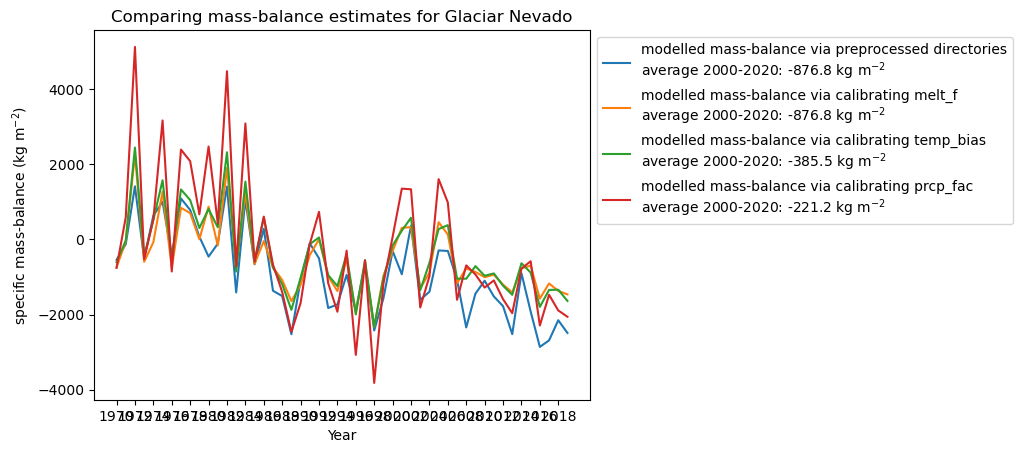

In [19]:
plt.plot(mbdf['mod_mb'],
         label='modelled mass-balance via preprocessed directories\n'+f'average 2000-2020: {mbdf.mod_mb.mean():.1f} ' + r'kg m$^{-2}$')
plt.plot(mbdf['mod_mb_melt_f'],
         label='modelled mass-balance via calibrating melt_f\n'+f'average 2000-2020: {mbdf.mod_mb.mean():.1f} ' + r'kg m$^{-2}$')
plt.plot(mbdf['mod_mb_temp_b'],
         label='modelled mass-balance via calibrating temp_bias\n'+f'average 2000-2020: {mbdf.mod_mb_temp_b.mean():.1f} ' + r'kg m$^{-2}$')
plt.plot(mbdf['mod_mb_prcp_fac'],
         label='modelled mass-balance via calibrating prcp_fac\n'+f'average 2000-2020: {mbdf.mod_mb_prcp_fac.mean():.1f} ' + r'kg m$^{-2}$')
plt.xticks(np.arange(1970,2020,2)) ## was from 2000, not 1970 
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel(r'specific mass-balance (kg m$^{-2}$)')
plt.xlabel('Year');
plt.title('Comparing mass-balance estimates for Glaciar Nevado')

In [20]:
# look at DataFrame that contains all the annual mass balance estimates 
# hmm 1) can I make this monthly instead of annually? 
mbdf

,mod_mb,mod_mb_melt_f,mod_mb_temp_b,mod_mb_prcp_fac
1970,-541.575297,-745.437601,-605.506063,-753.868286
1971,-124.651235,-49.678835,-27.788972,592.265030
1972,1416.834278,2268.428038,2450.581424,5132.846109
1973,-516.140483,-595.644829,-458.289179,-524.268763
1974,637.748548,-71.652101,520.352993,538.876342
1975,1006.927381,1274.999079,1579.363277,3171.877257
1976,-434.022738,-754.903881,-519.145901,-853.013661
1977,1093.348548,844.618750,1333.943743,2396.195966
1978,786.735708,703.902755,1050.809109,2087.417464
1979,74.283120,6.063134,306.321273,670.520369


In [21]:
# To export csv of mass balance estimates: 
mbdf.to_csv('mbdf_data.csv', index=False)

## Playing with warming scenarios: 

In [23]:
# Do a random run with a bit of warming
tasks.run_random_climate(gdir, 
                         ys=2020, ye=2100,  # Although the simulation is idealised, lets use real dates for the animation
                         y0=2009, halfsize=10,  # Randome climate of 1999-2019
                         seed=1,  # Random number generator seed 
                         temperature_bias=1.5,  # additional warming - change for other scenarios
                         store_fl_diagnostics=True,  # important! This will be needed for the redistribution
                         init_model_filesuffix='_spinup_historical',  # start from the spinup run
                         output_filesuffix='_random_s1',  # optional - here I just want to make things explicit as to which run we are using afterwards
                        );

In [24]:
# This is to add a new topography to the file (smoothed differently)
distribute_2d.add_smoothed_glacier_topo(gdir)
# This is to get the bed map at the start of the simulation
tasks.distribute_thickness_per_altitude(gdir)
# This is to prepare the glacier directory for the interpolation (needs to be done only once)
distribute_2d.assign_points_to_band(gdir)

In [26]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()

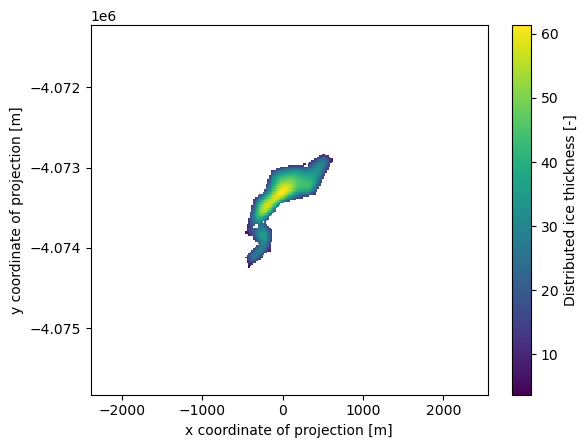

In [27]:
# Inititial glacier thickness
f, ax = plt.subplots()
ds.distributed_thickness.plot(ax=ax);
ax.axis('equal');

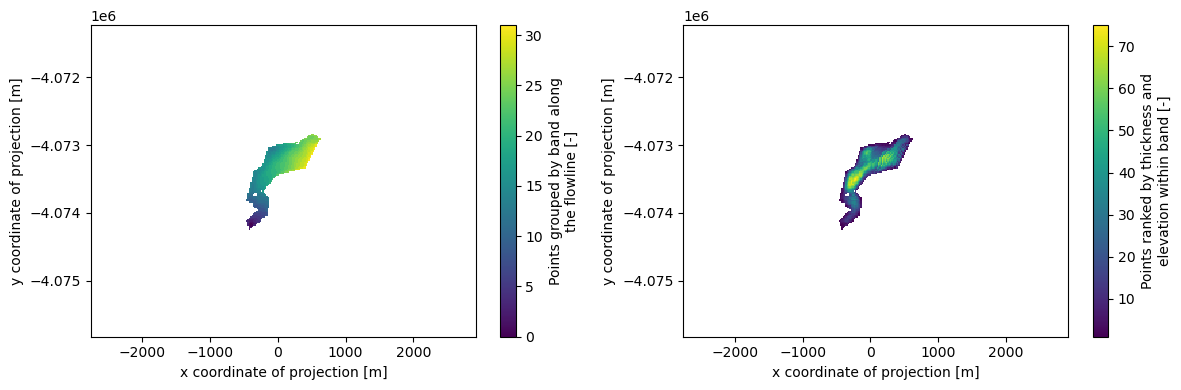

In [28]:
# Which points belongs to which band, and then within one band which are the first to melt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ds.band_index.plot(ax=ax1);
ds.rank_per_band.plot(ax=ax2);
ax1.axis('equal'); ax2.axis('equal'); plt.tight_layout();